# Project: **Finding Lane Lines on the Road** 
***

<div class="alert alert-block alert-warning" style="text-align: justify">Goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).
After, try it out on the video stream.</br>
**Tools:** color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.(** Later, explore and try other techniques that were not presented in the lesson**)
</div>

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> output should look like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Reading in Images.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


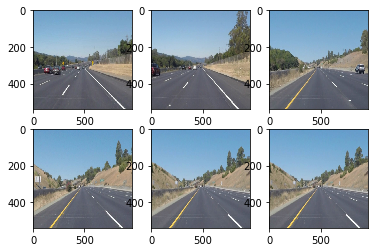

In [2]:
import os
#reading in images
test_images_input = os.listdir("test_images/")
images=[]
for image in  os.listdir("test_images/"):
    images.append(mpimg.imread(os.path.join("test_images/",image)))
    
for image in images:
    print('This image is:', type(image), 'with dimensions:', image.shape)
# plot with various axes scales
plt.figure(1)
plt.subplot(231)
plt.imshow(images[0],aspect='auto')

plt.subplot(232)
plt.imshow(images[1],aspect='auto')

plt.subplot(233)
plt.imshow(images[2],aspect='auto')

plt.subplot(234)
plt.imshow(images[3],aspect='auto')

plt.subplot(235)
plt.imshow(images[5],aspect='auto')

plt.subplot(236)
plt.imshow(images[5],aspect='auto')

## Helper Functions

In [7]:
import math
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)                        
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2: 
        channel_count = img.shape[2]                 
        ignore_mask_color = (255,) * channel_count   # 3 channel color mask
    else:
        ignore_mask_color = 255                      # 1 channel color mask
    # Fill the polygon defined by "vertices".  
    cv2.fillPoly(mask, vertices, ignore_mask_color)  
    masked_image = cv2.bitwise_and(img, mask)        
    return masked_image

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
#     for line in lines:
#         for x1_avg,y1_avg,x2_avg,y2_avg in line:
#             cv2.line(img, (x1_avg, y1_avg), (x2_avg, y2_avg), [255,20,147], thickness)
    """
    Average and/or extrapolate the line segments detected to map out the full extent of the lane lines.
    Details are written in writeup.md
    """
    verticle_lines=[]   #  m=infinity
    horizontal_lines=[] #  m=0
    left_lines=[]   #  m=+ve
    right_lines=[]   #  m=-ve
    postiveSlope=0     #  +veSlopeSUM
    negtiveSlope=0     #  -veSlopeSUM
#     Seperate Left lines & Right Lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2-y1)/(x2-x1) < 0.2 and (y2-y1)/(x2-x1) > -0.8:
                left_lines.append(line)
                postiveSlope+= ((y2-y1)/(x2-x1)) 
            elif (y2-y1)/(x2-x1) > 0.2 and (y2-y1)/(x2-x1) < 0.8:
                right_lines.append(line)
                negtiveSlope+= abs((y2-y1)/(x2-x1))                
#             # +ve slope --> left lane
#             if (y2-y1)/(x2-x1) > 0 and (y2-y1)/(x2-x1)!=float("inf") :
#                 left_lines.append(line)
#                 postiveSlope+= ((y2-y1)/(x2-x1))
#             # -ve slope --> right lane
#             elif(y2-y1)/(x2-x1) < 0 and (y2-y1)/(x2-x1)!= float("-inf") :
#                 right_lines.append(line)
#                 negtiveSlope+= abs((y2-y1)/(x2-x1))
#             # INFINITY slope --> i.e only verticle { (x2-x1)== 0 }
#             elif (y2-y1)/(x2-x1)== float("inf") or (y2-y1)/(x2-x1)== float("-inf")   :
#                 verticle_lines.append(line)
#             # 0 slope --> only horizontal
#             elif (y2-y1)/(x2-x1) ==0 :
#                 # x-axis <500 --> left lane.
#                 if x2<500 or x1<500:
#                     left_lines.append(line)
#                 # x-axis >500 --> right lane
#                 else:
#                     right_lines.append(line)
#    coordinates average left_lanes , right_lanes
    LL_avg= np.average(left_lines, axis=0)
#     print('LL_avg',LL_avg)
    RL_avg= np.average(right_lines, axis=0)
#     print('RL_avg',RL_avg)
#    calculate the slope_avg & Intercept_avg for left_lanes , right_lanes
    for x1_avg,y1_avg,x2_avg,y2_avg in LL_avg:
#         print(x1_avg,y1_avg,x2_avg,y2_avg)
        LL_slope_avg     = (y2_avg - y1_avg)/(x2_avg - x1_avg)+1
        LL_Intercept_avg = y1_avg - (LL_slope_avg * x1_avg)
        
    for x1_avg,y1_avg,x2_avg,y2_avg in RL_avg:
#         print(x1_avg,y1_avg,x2_avg,y2_avg)
        RL_slope_avg     = (y2_avg - y1_avg)/(x2_avg - x1_avg)-1
        RL_Intercept_avg = y1_avg - (RL_slope_avg * x1_avg)
        
#    Calc the Lowest coordinate for left_lanes & right_lanes using x = (y - b)/m
    min_left_y  =  539#find_minimum_y(left_lines)
    min_left_x  =  880#calculate_x(min_left_y, LL_Intercept_avg, LL_slope_avg) #affecting right line
    
    min_right_y =  539#find_minimum_y(right_lines)
    min_right_x =  180#calculate_x(min_right_y, RL_Intercept_avg, RL_slope_avg) # affecting left line..?

#    Calc the highest coordinate for left_lanes & right_lanes using x = (y - b)/m
    max_left_y  =  280#find_maximum_y(left_lines)
    max_left_x  =  430#calculate_x(max_left_y,LL_Intercept_avg, LL_slope_avg) # affecting right line..?
    
    max_right_y =  260#find_maximum_y(right_lines)    
    max_right_x =  550#calculate_x(max_right_y,RL_Intercept_avg, RL_slope_avg)
#     print('Final LEFT coordinates  :','Min x:',min_left_x,'for fixed Min y:', min_left_y,'Max x :',max_left_x,'for fixed Max y:',max_left_y)
#     print('Final RIGHT coordinates :','Min x:',min_right_x,'for fixed Min y:', min_right_y,'Max x:',max_right_x,'for fixed Max y:',max_right_y)
    """
    This function draws `lines` with `color` and `thickness`. 
    If you want to make the lines semi-transparent, 
    think about combining this function with the weighted_img() function below
    """
#     print('Image over')
#   left_lane_lines drawn:  ==================                                         
    cv2.line(img, (min_left_x, min_left_y), (max_left_x, max_left_y), [255,255,0], thickness)
#   right_lane_lines drawn  ==================  
    cv2.line(img, (min_right_x, min_right_y), (max_right_x, max_right_y), [0,0,255], thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # by using the dimensions of original image, creating a complete Blacked out copy of it.
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) 
    # calling the draw_lines function, which will draws lines on
    # the hough returned coordinates in fully Blacked-out Image.
    draw_lines(line_img, lines)                                             
    # this image has connected(line drawn) coordinates in complete Black-out image. 
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Added Helper functions to support draw_lines() .

In [8]:
'''
Question: I still did not get clarity on Why I have to calculate x when I can retrive exact x_min for y_min as well as maxs.?????????
slope intercept form(x = (y - b)/m)
'''    
def calculate_x(y,intercept, slope):
    x= ((y-intercept)//slope)
    return int(x)
'''
This function simply calculates the min of all y's (y1 & y2) and catches their corresponding x's., But due to the issue mentioned above
I calculted x's for y's with the help of calc_x() function.
'''
def find_minimum_y(lane_lines):
    for line in lane_lines:
        temp=960
        temp1=960
        for x1,y1,x2,y2 in line:
            if temp>=y1:
                temp=y1
                if temp==y1:
                    temp_x1=x1
            if temp1>=y2:
                temp1=y2
                if temp1==y2:
                    temp1_x2=x2
    if temp<temp1:
        min_y=temp
        min_x=temp_x1
    else:
        min_y=temp1
        min_x=temp1_x2
    return int(min_y)
'''
function calculate maximum y
'''
def find_maximum_y(lane_lines):
    for line in lane_lines:
        temp=0
        temp1=0
        for x1,y1,x2,y2 in line:
            if temp<=y1:
                temp=y1
                if temp==y1:
                    temp_x1=x1
            if temp1<=y2:
                temp1=y2
                if temp1==y2:
                    temp1_x2=x2
    if temp>temp1:
        max_y=temp
        max_x=temp_x1
    else:
        max_y=temp1
        max_x=temp1_x2    
    return int(max_y) 

## Reading Test Images

In [10]:
import os,re
INPUT_PATH  = 'test_images/'
OUTPUT_PATH = 'test_images_output/'
# Automate the data fetching process.
def read_save_images(input_dir=INPUT_PATH, output_dir=OUTPUT_PATH):           
    #     read input images into a list
    test_images_input = os.listdir(input_dir)                                 
    #     output directory doesn't exist then create one
    if not os.path.isdir(output_dir):                                         
        os.makedirs(output_dir)
    
    for text_images in test_images_input:
        # read each image into program
        image = mpimg.imread( os.path.join(input_dir,text_images))   
        # send this image to your pipeline to process it
        pipeLine_output_image = laneFindingPipeLine(image)                    
        modify_name = re.sub(r'\.jpg$', '', text_images)
        # put the final image into the directory
        mpimg.imsave( os.path.join(output_dir,modify_name+'_output.jpg'),pipeLine_output_image) 
    return  

### Calling the pipeline

In [11]:
# simply calling the pipeline here
read_save_images()

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in int_scalars
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in int_scalars


## Building a Lane Finding Pipeline

In [9]:
def laneFindingPipeLine(img):
#     plt.figure(2)
#     print('Original_image shape',img.shape )
#     plt.subplot(331)
#     plt.imshow(img,aspect='auto')
    '''
     to apply canny algorithm, convert color image to gray i,e a single channel image
     gray image helps us to clearly identify, DARK/ BRIGHT/ GRAY(in between) pixels in the image. 
     Also, rapid changing in the brightess, we will be able to find edges/dots
    '''
    gray_image = grayscale(img)
#     print('gray_image shape',gray_image.shape )
#     plt.subplot(332)
#     plt.imshow(gray_image,aspect='auto')
    
    '''
    filter-out noise and spurious gradients by averaging  with gaussian filter, keeping Kernel_size = 5, **always select a odd size number.
    '''
    kernel_size=5
    blur_gray = gaussian_blur(gray_image, kernel_size)
#     print('blur_gray shape',blur_gray.shape )
#     plt.subplot(333)
#     plt.imshow(blur_gray,aspect='auto')
    '''
    now, we can apply canny algorithm, that
    apply its gaussian filter--> finds the gradient strength & direction(you get thick edges)-->apply non-max. suppression(get thin/candidate edges)-->Hysteresis with the help of thresholds specifies in the arguments
    '''
    low_threshold  = 70
    high_threshold = 140
    canny_edges = canny(blur_gray, low_threshold, high_threshold)
#     print('canny_edges shape',canny_edges.shape )
#     plt.subplot(334)
#     plt.imshow(canny_edges,aspect='auto')
    '''
    Work is not done YET..!!
    We just have dotted-lane-lines detected.
    So, we connect them..? How we know which dot to connect with which other dot, & how many dots to connect? ...TRICKY SITUATION...!!!
    Awesome Manipulation by hough, We have dots in our image space, which equivalent to a line for each dot in Hough space. And, collinear points in image space
    is equivalent to respective lines passing through common intersection point/pixel in Hough space. Also, in Hough space we have grids cells, which helps to 
    catch all the edges/dots in images space which are not collinear but very much near to collinear points by adjusting THRESHOLD parameter in below function.
    The more count we get of lines passing through a grid pixel in hough space, the more we get collinear/near-collinear edges/dots in out image space.
    This way we will be able to clear identify the sequence of coordinates of all near-collinear points in the canny_edge_detected_masked_image ....AMAZING..!!
    
    Now, you have the coordinates, Connect them with a line, by calling custom draw_lines()
    '''
    rho = 1
    theta = np.pi/180
    threshold = 12
    min_line_len = 10
    max_line_gap = 2
    line_img = hough_lines(canny_edges, rho, theta, threshold, min_line_len, max_line_gap) # --> will call draw lines & you get a Blacked-out image with connected Hough returned coordinates.
#     print('line_img shape',line_img.shape )
#     plt.subplot(335)
#     plt.imshow(line_img,aspect='auto')
    '''
    Now, you have a edge-detected image : which has edges all over the image based on you detection criterion. This doesn't solve our purpose. 
    We need to narrow-down our area of visibility to not to let our algorithm confuse.
    Create a region of interest, a polygon around the specific lane line.
    This function takes the coordinates of the polygon and draws a polygon in the image,
    then fill with a RED color <-- this becomes your mask.(a specific area to look on.)
    then it performs bitwise AND with canny_edge_detected_image(which is full of edges everywhere) & mask_image(just a plane RED POLYGON SHAPE in the image)--> gives a canny_edge_detected_masked_image
    So, now you have clear RED-HIGHLIGHTNED canny- edges....BEAUTIFULL..!!! :)
    
    Note: Create a mask is independent of any operatio, Moreover, you want to create Mask on the line_image that's why you have to 
          do a bit-wise AND to get only the masked-line Image. Do not repeat it again...!!!!
    '''
    vertices = np.array([[(0,539),(425, 340), (510, 320), (959,539)]], dtype=np.int32)
    masked_image = region_of_interest(img, vertices)
#     print('masked_image shape',masked_image.shape )
#     plt.subplot(336)
#     plt.imshow(masked_image,aspect='auto')
    '''
    have to mask the line_image so that we can get the specific area in the image to look on
    '''
    masked_line_img = cv2.bitwise_and(masked_image, line_img)
#     print('masked_line_img shape',masked_line_img.shape )
#     plt.subplot(337)
#     plt.imshow(masked_line_img,aspect='auto')
    '''
    now we have 1. a image with hough generated connected coordinates
                2. a image with masked-region(polygon) with canny detected edges. 
    this function will give weights to each pixel & glue them together. 
    Remember, before gluing, the dimension shoudld be same, else it pops out errors.
    img==1 & initial_img==2(original image)
    '''
    output = weighted_img(masked_line_img, img, α=0.8, β=1., λ=0.)
#     print('output shape',output.shape )
#     plt.subplot(338)
#     plt.imshow(output,aspect='auto')
    return output

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output shape (540, 960, 4)


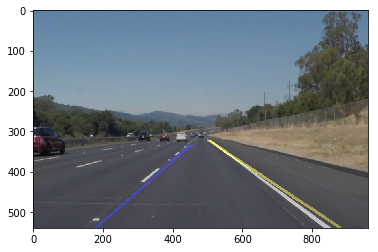

In [13]:
if not os.path.isdir('test_videos_output/'):         #     output directory doesn't exist then create one
        os.makedirs('test_videos_output/')
    
image = mpimg.imread(os.path.join('test_images_output/solidWhiteRight_output.jpg'))
print('output shape',image.shape )
plt.imshow(image,aspect='auto') 
plt.show()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)  
    result = laneFindingPipeLine(image)   
    return result                    

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 75.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.86 s, sys: 321 ms, total: 3.19 s
Wall time: 3.31 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [8]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

NameError: name 'VideoFileClip' is not defined

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

NameError: name 'HTML' is not defined